tgb - 4/22/2019  
- Figures from notebook 010
- We will train unconstrained (U), loss-constrained (L) and architecture-constrained (A) neural networks trained on the 8-column +0K experiment and validated on the same experiment. The loss-constrained networks will have varying architectures to see how MSE and energy conservation performances vary with the importance given to each in the loss function.  
  
Notebook 009 follows the notebook 005 that predicts:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

# 1) Load modules and create training/validation data generators

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 2) Load model and statistics

In [88]:
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints

MSEa = {}; MASa = {}; ENTa = {}; SWa = {}; LWa = {}; PENa = {};
for alpha in alpha_array:
    NN = {}; md = {};
    print('alpha = ',str(alpha))
    # 0) Define model/statistics to load
    config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
    data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
    dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
    # Path of model/statistics
    path_model = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
    path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'

    # 1) Load model
    NN = load_model(path_model,custom_objects=dict_lay)

    # 2) Define and load md
    md = ModelDiagnostics(NN,config_fn,data_fn)
    md.stats = pickle.load(open(path_md,'rb'))

    # 3) Load res
    md.res = pickle.load(open(path_res,'rb'))

    # 4) Fill the MSE and energy/enthalpy arrays as function of alpha
    MSEa[str(alpha)] = md.mse_W2m4().mean((0,1,2))
    MASa[str(alpha)] = md.res['mass'].mean((0,1,2))
    ENTa[str(alpha)] = md.res['ent'].mean((0,1,2))
    SWa[str(alpha)] = md.res['sw'].mean((0,1,2))
    LWa[str(alpha)] = md.res['lw'].mean((0,1,2))
    PENa[str(alpha)] = 0.25*(md.res['mass']+md.res['ent']+\
                             md.res['sw']+md.res['lw']).mean((0,1,2))
    
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/NNA.h5'
path_md = TRAINDIR+'HDF5_DATA/NNAmd.pkl'
path_res = TRAINDIR+'HDF5_DATA/NNAres.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['NNA'] = md.mse_W2m4().mean((0,1,2))
PENa['NNA'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))

alpha =  0
alpha =  0.01
alpha =  0.25
alpha =  0.5
alpha =  0.75
alpha =  0.99
alpha =  1
Instructions for updating:
Use tf.cast instead.


In [78]:
# tgb - 4/22/2019 - Brewer color palettes from Github colorbrewer-python-master
Set1 = {
    3: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)'],
    4: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)'],
    5: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)'],
    6: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)'],
    7: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)'],
    8: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)'],
    9: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']
}
Set2 = {
    3: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)'],
    4: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)'],
    5: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)'],
    6: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)'],
    7: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)', 'rgb(229,196,148)'],
    8: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)', 'rgb(229,196,148)', 'rgb(179,179,179)']
}
Set3 = {
    3: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)'],
    4: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)'],
    5: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)'],
    6: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)'],
    7: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)'],
    8: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)'],
    9: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)'],
    10: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)'],
    11: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)'],
    12: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)', 'rgb(255,237,111)']
}
print(Set1[9])

['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']


In [94]:
eval(cmap[1][3:])
MSEa['NNA']

168.94318558526123

alpha =  0
alpha =  0.01
alpha =  0.25
alpha =  0.5
alpha =  0.75
alpha =  0.99
alpha =  1


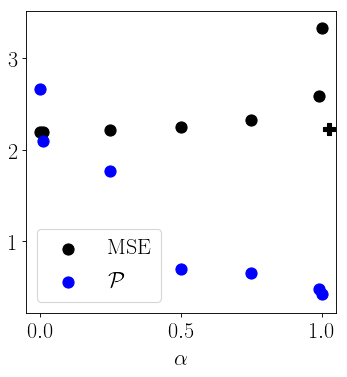

In [103]:
import matplotlib.pyplot as plt

fz = 20
lw = 4
siz = 100

MSEs = {}; MASs = {}; ENTs = {}; LWs = {}; SWs = {}; PENs = {};

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

for alpha in alpha_array:
    print('alpha = ',str(alpha))
    MSEs[str(alpha)] = plt.scatter(alpha,np.log10(MSEa[str(alpha)]),c='k',s=siz)
    PENs[str(alpha)] = plt.scatter(alpha,np.log10(PENa[str(alpha)]),c='b',s=siz)
    
MSEs['NNA'] = plt.scatter(1.025,np.log10(MSEa['NNA']),c='k',s=siz,marker="P")
# PENs['NNA'] = plt.scatter(0.5,np.log10(PENa['NNA']),c='b',linewidths=lw,marker="P")
    
plt.xlim((-0.05,1.05))
plt.xlabel(r'$\alpha$', fontsize = 20)
plt.legend((MSEs['0'],PENs['0']),\
           ('MSE','$\cal{P}$'))
# plt.legend((MSEs['0'],PENs['0'],MSEs['NNA'],PENs['NNA']),\
#            ('MSE','$\cal{P}$','MSE NNA','$\cal{P}\ \mathrm{NNA}$'))

tgb - 4/18/2019 - Used preprocessed data calculated in notebook 009 @ https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/009_Generalization_Climate_Change_8col.ipynb

In [6]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl')

train_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)
valid_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'valid.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=False
)

# 2) Build neural networks in a loop
tgb - 4/18/2019 - https://stackoverflow.com/questions/52320059/creating-a-new-sequential-model-inside-a-for-loop-using-keras

In [15]:
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
Nep = 1

for alpha in alpha_array:
    NN = {}
    print('alpha = ',str(alpha),' and NN is ',NN)
    graph = tf.Graph()
    with tf.Session(graph=graph):
        
        # 1) Create model
        # Unconstrained model with 5 dense layers (Notebook 009)
        inpU = Input(shape=(304,))
        densout = Dense(512, activation='linear')(inpU)
        densout = LeakyReLU(alpha=0.3)(densout)
        for i in range (4):
            densout = Dense(512, activation='linear')(densout)
            densout = LeakyReLU(alpha=0.3)(densout)
        densout = Dense(218, activation='linear')(densout)
        out_layer = LeakyReLU(alpha=0.3)(densout)
        NN = tf.keras.models.Model(inpU, out_layer)
        print('NN is ',NN.summary())
        
        # 2) Define loss
        al = alpha/4 # Weight given to each residual
        Loss = WeakLoss(inpU, inp_div=train_gen.input_transform.div,
                            inp_sub=train_gen.input_transform.sub,
                            norm_q=scale_dict['PHQ'],
                            hyai=hyai, hybi=hybi, name='loss',
                            alpha_mass=al, alpha_ent=al,
                            alpha_lw=al, alpha_sw=al)
        
        # 3) Compile model
        NN.compile(tf.keras.optimizers.RMSprop(), loss=Loss, metrics=[mse])
        
        # 4) Train model
        NN.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen)
        
        # 5) Save model
        path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
        NN.save(path)
        print('NN saved in ',path)

alpha =  0  and NN is  {}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 304)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               156160    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)          

KeyboardInterrupt: 

In [ ]:
# Repeat for architecture-constrained network
graph = tf.Graph()
with tf.Session(graph=graph):

    # 1) Create model
    # Unconstrained model with 5 dense layers (Notebook 009)
    inpC = Input(shape=(304,))
    densout = Dense(512, activation='linear')(inpC)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (4):
        densout = Dense(512, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    densout = Dense(214, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
    surfout = SurRadLayer(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi
    )([inpC, densout])
    massout = MassConsLayer(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi
    )([inpC, surfout])
    enthout = EntConsLayer(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi
    )([inpC, massout])
    NNA = tf.keras.models.Model(inpC, enthout)
    print(NNA.summary())

    # 2) Compile model
    NNA.compile(tf.keras.optimizers.RMSprop(), loss=mse, metrics=[mse])

    # 3) Train model
    NNA.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen)

    # 4) Save model
    path = TRAINDIR+'HDF5_DATA/NNA.h5'
    NNA.save(path)
    print('NN saved in ',path)

## 3) Calculate statistics and residuals in a loop

## 3.1) Load models to test statistics
tgb - 4/19/2019 - Debugging

In [8]:
# config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
# data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
# dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

# %cd $TRAINDIR/HDF5_DATA
# !ls
# dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
# alpha = 0
# path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
# NN = load_model(path,custom_objects=dict_lay)
# md = ModelDiagnostics(NN,config_fn,data_fn)
    
# # 3) Calculate statistics and save in pickle file
# md.compute_stats(niter=5)
# path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
# pickle.dump(md.stats,open(path,'wb'))
# print('Stats are saved in ',path)

# # 4) Calculate budget residuals and save in pickle file
# md.compute_res(niter=5)
# path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'
# pickle.dump(md.res,open(path,'wb'))
# print('Budget residuals are saved in ',path)

## 3.2) Statistics

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

for alpha in alpha_array:
    
    # 1) Load model
    path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
    NN = load_model(path,custom_objects=dict_lay)
    
    # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    
    # 3) Calculate statistics and save in pickle file
    md.compute_stats()
    path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
    pickle.dump(md.stats,open(path,'wb'))
    print('Stats are saved in ',path)
    
    # 4) Calculate budget residuals and save in pickle file
    md.compute_res()
    path = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'
    pickle.dump(md.res,open(path,'wb'))
    print('Budget residuals are saved in ',path)

### Statistics of architecture-constrained neural network

In [2]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

# 1) Load model
path = TRAINDIR+'HDF5_DATA/NNA.h5'
NN = load_model(path,custom_objects=dict_lay)

# 2) Define model diagnostics object
md = ModelDiagnostics(NN,config_fn,data_fn)

# 3) Calculate statistics and save in pickle file
# md.compute_stats()
# path = TRAINDIR+'HDF5_DATA/NNAmd.pkl'
# pickle.dump(md.stats,open(path,'wb'))
# print('Stats are saved in ',path)

# 4) Calculate budget residuals and save in pickle file
md.compute_res()
path = TRAINDIR+'HDF5_DATA/NNAres.pkl'
pickle.dump(md.res,open(path,'wb'))
print('Budget residuals are saved in ',path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 